In [1]:
import os
os.chdir("..")

In [2]:
import pandas as pd
import torch
from matplotlib import pyplot as plt

import utils
import linear_explanation

In [3]:
# dataset_name = "imagenet_val"
# target_name = "resnet50_imagenet"
# target_layer = "layer4"
# pool_mode = "avg"

# dataset_name = "places365_val"
# target_name = "resnet18_places365"
# target_layer = "layer4"
# pool_mode = "avg"

# dataset_name = "cifar100_val"
# target_name = "vgg16_bn_cifar100"
# target_layer = "classifier[4]"
# pool_mode = "avg"

# dataset_name = "imagenet_val"
# target_name = "vit_b_16_imagenet"
# target_layer = "encoder.layers.encoder_layer_11.mlp[1]"
# pool_mode = "first"

dataset_name = "imagenet_val"
target_name = "vit_l_32_imagenet"
target_layer = "encoder.layers.encoder_layer_23.mlp[1]"
pool_mode = "first"

# dataset_name = "imagenet_val"
# target_name = "vit_l_16_imagenet"
# target_layer = "encoder.layers.encoder_layer_23.mlp[1]"
# pool_mode = "first"

activations_dir = "saved_activations"
device = "cpu"

In [4]:
target_activations = linear_explanation.get_target_acts(target_name = target_name, dataset_name = dataset_name,
                                                            target_layer = target_layer, save_dir = activations_dir,
                                                            batch_size = 128, device = device, pool_mode=pool_mode)

neuron_maxs = torch.max(target_activations, dim=0)[0]
neuron_maxs.cpu()

tensor([1.8896, 5.6758, 3.5020,  ..., 3.1562, 2.5645, 2.7305])

Text(0.5, 0, 'Neuron id(sorted)')

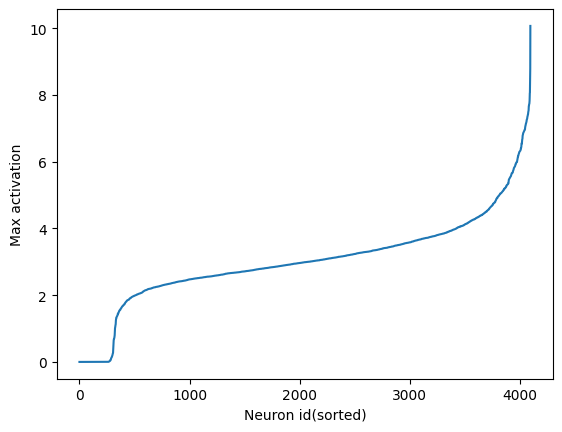

In [5]:
plt.plot((neuron_maxs.sort()[0]).cpu().numpy())
plt.ylabel("Max activation")
plt.xlabel("Neuron id(sorted)")

In [6]:
torch.sum(neuron_maxs < 0.01)/len(neuron_maxs)

tensor(0.0657)

In [7]:
for explanation_method in ["clip_dissect", "le_label", "le_siglip"]:
    explanation_path = utils.EXPLANATION_PATHS[explanation_method] + "{}_{}.csv".format(target_name, target_layer)
    results_df = pd.read_csv(explanation_path)
    correlations = results_df["sim correlation"]
    print("{} Average correlation: {:.4f} +- {:.4f}".format(explanation_method, torch.mean(torch.tensor(correlations)),
                                                        torch.std(torch.tensor(correlations))/(len(correlations))**0.5))

clip_dissect Average correlation: 0.0549 +- 0.0022
le_label Average correlation: 0.1879 +- 0.0038
le_siglip Average correlation: 0.2182 +- 0.0037


In [8]:
for explanation_method in ["clip_dissect", "le_label", "le_siglip"]:
    explanation_path = utils.EXPLANATION_PATHS[explanation_method] + "{}_{}.csv".format(target_name, target_layer)
    results_df = pd.read_csv(explanation_path)
    correlations = results_df["sim correlation"]
    non_dead_correlations = torch.tensor(correlations)[neuron_maxs>0.01]
    print("{} Average correlation: {:.4f} +- {:.4f}".format(explanation_method, torch.mean(non_dead_correlations),
                                                        torch.std(non_dead_correlations)/(len(non_dead_correlations))**0.5))

clip_dissect Average correlation: 0.0590 +- 0.0024
le_label Average correlation: 0.1984 +- 0.0040
le_siglip Average correlation: 0.2254 +- 0.0039


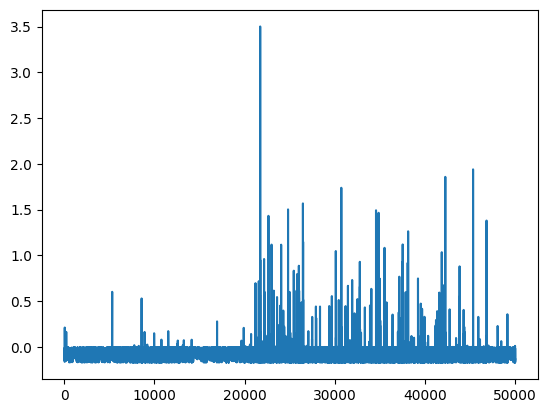

In [10]:
plt.plot(target_activations[:, 2])